# Load Dataset

In [1]:
import os
from glob import glob
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
import random
import cv2

class CustomDataset(Dataset):
    def __init__(self, list_imgs, list_masks, transform=None):
        self.list_imgs = list_imgs
        self.list_masks = list_masks
        self.transform = transform

    def __len__(self):
        return len(self.list_imgs)

    def __getitem__(self, index):
        img_path = self.list_imgs[index]
        mask_path = self.list_masks[index]

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # 이미지 크기를 512x512로 변경
        img = cv2.resize(img, (512, 512), interpolation=cv2.INTER_LINEAR)
        mask = cv2.resize(mask, (512, 512), interpolation=cv2.INTER_NEAREST)

        img = img.astype(np.float32) / 255.0
        mask = mask.astype(np.float32) / 255.0

        if img.ndim == 2:
            img = img[:, :, np.newaxis]
        if mask.ndim == 2:
            mask = mask[:, :, np.newaxis]

        data = {'input': img, 'label': mask}

        if self.transform:
            data = self.transform(data)
        
        return data

def create_datasets(img_dir, mask_dir, train_ratio=0.7, val_ratio=0.2, transform=None):
    list_imgs = sorted(glob(os.path.join(img_dir, '**', '*.png'), recursive=True))
    list_masks = sorted(glob(os.path.join(mask_dir, '**', '*.png'), recursive=True))

    combined = list(zip(list_imgs, list_masks))
    random.shuffle(combined)
    list_imgs, list_masks = zip(*combined)

    num_imgs = len(list_imgs)
    num_train = int(num_imgs * train_ratio)
    num_val = int(num_imgs * val_ratio)

    train_set = CustomDataset(list_imgs[:num_train], list_masks[:num_train], transform)
    val_set = CustomDataset(list_imgs[num_train:num_train + num_val], list_masks[num_train:num_train + num_val], transform)
    test_set = CustomDataset(list_imgs[num_train + num_val:], list_masks[num_train + num_val:], transform)

    return train_set, val_set, test_set



C:\Users\pinb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Test Dataset Loader

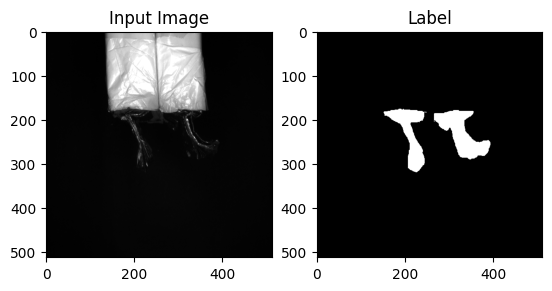

In [2]:
# 사용 예시
dir_img = 'C:/Users/pinb/Desktop/imgs'
dir_mask = 'C:/Users/pinb/Desktop/masks'
train_set, val_set, test_set = create_datasets(dir_img, dir_mask)

# 첫 번째 이미지 확인 (예: train set)
data = train_set.__getitem__(7777)  # 이미지 불러오기

input_img = data['input']
label = data['label']

# 이미지 시각화
plt.subplot(121)
plt.imshow(input_img.reshape(input_img.shape[0], input_img.shape[1]), cmap='gray')
plt.title('Input Image')

plt.subplot(122)
plt.imshow(label.reshape(label.shape[0], label.shape[1]), cmap='gray')
plt.title('Label')

plt.show()

# Argumentation

In [3]:
# 트렌스폼 구현하기
class ToTensor(object):
    # def __call__(self, data):
    #     label, input = data['label'], data['input']

    #     label = label.transpose((2, 0, 1)).astype(np.float32)
    #     input = input.transpose((2, 0, 1)).astype(np.float32)

    #     data = {'label': torch.from_numpy(label), 'input': torch.from_numpy(input)}

    #     return data
    def __call__(self, data):
        label, input = data['label'], data['input']

        # 이미지가 이미 그레이스케일이면 채널 차원 추가
        if label.ndim == 2:
            label = label[:, :, np.newaxis]
        if input.ndim == 2:
            input = input[:, :, np.newaxis]

        # 채널을 첫 번째 차원으로 이동
        label = label.transpose((2, 0, 1)).astype(np.float32)
        input = input.transpose((2, 0, 1)).astype(np.float32)

        data = {'label': torch.from_numpy(label), 'input': torch.from_numpy(input)}

        return data

class Normalization(object):
    def __init__(self, mean=0.5, std=0.5):
        self.mean = mean
        self.std = std

    def __call__(self, data):
        label, input = data['label'], data['input']

        input = (input - self.mean) / self.std

        data = {'label': label, 'input': input}

        return data

class RandomFlip(object):
    def __call__(self, data):
        label, input = data['label'], data['input']

        if np.random.rand() > 0.5:
            label = np.fliplr(label)
            input = np.fliplr(input)

        if np.random.rand() > 0.5:
            label = np.flipud(label)
            input = np.flipud(input)

        data = {'label': label, 'input': input}

        return data
    
# class Resize(object):
#     def __init__(self, output_size):
#         assert isinstance(output_size, (int, tuple))
#         self.output_size = output_size

#     def __call__(self, data):
#         label, input = data['label'], data['input']

#         h, w = input.shape[:2]
#         if isinstance(self.output_size, int):
#             if h > w:
#                 new_h, new_w = self.output_size * h / w, self.output_size
#             else:
#                 new_h, new_w = self.output_size, self.output_size * w / h
#         else:
#             new_h, new_w = self.output_size

#         new_h, new_w = int(new_h), int(new_w)

#         input = cv2.resize(input, (new_w, new_h))
#         label = cv2.resize(label, (new_w, new_h))

#         return {'label': label, 'input': input}

class Rotate(object):
    def __init__(self, angle_range):
        assert isinstance(angle_range, (tuple, list)) and len(angle_range) == 2
        self.angle_min, self.angle_max = angle_range

    def __call__(self, data):
        label, input = data['label'], data['input']

        # NumPy 배열로 변환 (필요한 경우)
        if not isinstance(input, np.ndarray):
            input = np.array(input)
        if not isinstance(label, np.ndarray):
            label = np.array(label)

        # (H, W, C) 형태를 (H, W)로 변경 (필요한 경우)
        if input.ndim == 3 and input.shape[2] == 1:
            input = input.squeeze(2)
        if label.ndim == 3 and label.shape[2] == 1:
            label = label.squeeze(2)

        # 랜덤 각도 선택 및 회전 적용
        angle = np.random.uniform(self.angle_min, self.angle_max)
        h, w = input.shape[:2]
        center = (w / 2, h / 2)
        rot_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
        input = cv2.warpAffine(input, rot_matrix, (w, h))
        label = cv2.warpAffine(label, rot_matrix, (w, h))

        return {'label': label, 'input': input}
    
# class Crop(object):
#     def __init__(self, output_size):
#         assert isinstance(output_size, (int, tuple))
#         if isinstance(output_size, int):
#             self.output_size = (output_size, output_size)
#         else:
#             assert len(output_size) == 2
#             self.output_size = output_size

#     def __call__(self, data):
#         label, input = data['label'], data['input']

#         h, w = input.shape[:2]
#         new_h, new_w = self.output_size

#         top = np.random.randint(0, h - new_h)
#         left = np.random.randint(0, w - new_w)

#         input = input[top: top + new_h, left: left + new_w]
#         label = label[top: top + new_h, left: left + new_w]

#         return {'label': label, 'input': input}


# Test Arguemtation

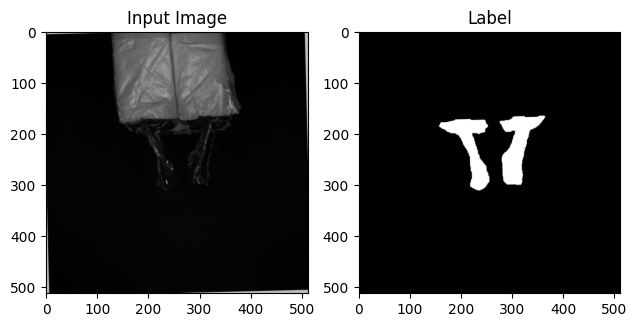

In [4]:
# 트랜스폼 잘 구현되었는지 확인
transform = transforms.Compose([Normalization(mean=0.5, std=0.5), RandomFlip(), Rotate(angle_range=(-90, 90)), ToTensor()])

dir_img = 'C:/Users/pinb/Desktop/imgs'
dir_mask = 'C:/Users/pinb/Desktop/masks'
train_set, val_set, test_set = create_datasets(img_dir=dir_img, mask_dir=dir_mask, transform=transform)


data = train_set.__getitem__(12599) # 한 이미지 불러오기
input = data['input']
label = data['label']

# 불러온 이미지 시각화
plt.subplot(122)
plt.hist(label.flatten(), bins=20)
plt.title('label')

plt.subplot(121)
plt.hist(input.flatten(), bins=20)
plt.title('input')

# 이미지 시각화
plt.subplot(121)
plt.imshow(input.squeeze(), cmap='gray')
plt.title('Input Image')

plt.subplot(122)
plt.imshow(label.squeeze(), cmap='gray')
plt.title('Label')

plt.tight_layout()
plt.show()

# Model Network (Origin)

In [18]:
## 라이브러리 불러오기
import os
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt

## 네트워크 구축하기
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Convolution + BatchNormalization + Relu 정의하기
        def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True): 
            layers = []
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                 kernel_size=kernel_size, stride=stride, padding=padding,
                                 bias=bias)]
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            layers += [nn.ReLU()]

            cbr = nn.Sequential(*layers)

            return cbr

        # 수축 경로(Contracting path)
        self.enc1_1 = CBR2d(in_channels=1, out_channels=64)
        self.enc1_2 = CBR2d(in_channels=64, out_channels=64)

        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.enc2_1 = CBR2d(in_channels=64, out_channels=128)
        self.enc2_2 = CBR2d(in_channels=128, out_channels=128)

        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.enc3_1 = CBR2d(in_channels=128, out_channels=256)
        self.enc3_2 = CBR2d(in_channels=256, out_channels=256)

        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.enc4_1 = CBR2d(in_channels=256, out_channels=512)
        self.enc4_2 = CBR2d(in_channels=512, out_channels=512)

        self.pool4 = nn.MaxPool2d(kernel_size=2)

        self.enc5_1 = CBR2d(in_channels=512, out_channels=1024)

        # 확장 경로(Expansive path)
        self.dec5_1 = CBR2d(in_channels=1024, out_channels=512)

        self.unpool4 = nn.ConvTranspose2d(in_channels=512, out_channels=512,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec4_2 = CBR2d(in_channels=2 * 512, out_channels=512)
        self.dec4_1 = CBR2d(in_channels=512, out_channels=256)

        self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec3_2 = CBR2d(in_channels=2 * 256, out_channels=256)
        self.dec3_1 = CBR2d(in_channels=256, out_channels=128)

        self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec2_2 = CBR2d(in_channels=2 * 128, out_channels=128)
        self.dec2_1 = CBR2d(in_channels=128, out_channels=64)

        self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec1_2 = CBR2d(in_channels=2 * 64, out_channels=64)
        self.dec1_1 = CBR2d(in_channels=64, out_channels=64)

        self.fc = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)
    
    # forward 함수 정의하기
    def forward(self, x):
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)

        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool3(enc3_2)

        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)

        enc5_1 = self.enc5_1(pool4)

        dec5_1 = self.dec5_1(enc5_1)

        unpool4 = self.unpool4(dec5_1)
        cat4 = torch.cat((unpool4, enc4_2), dim=1)
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)

        unpool3 = self.unpool3(dec4_1)
        cat3 = torch.cat((unpool3, enc3_2), dim=1)
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)

        unpool2 = self.unpool2(dec3_1)
        cat2 = torch.cat((unpool2, enc2_2), dim=1)
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)

        unpool1 = self.unpool1(dec2_1)
        cat1 = torch.cat((unpool1, enc1_2), dim=1)
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)

        x = self.fc(dec1_1)

        return x

# Model Network (Mini)

In [ ]:
## 라이브러리 불러오기
import os
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt

## 네트워크 구축하기
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Convolution + BatchNormalization + Relu 정의하기
        def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True): 
            layers = []
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                 kernel_size=kernel_size, stride=stride, padding=padding,
                                 bias=bias)]
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            layers += [nn.ReLU()]

            cbr = nn.Sequential(*layers)

            return cbr

        # 수축 경로(Contracting path)
        self.enc1_1 = CBR2d(in_channels=1, out_channels=64)
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.enc2_1 = CBR2d(in_channels=64, out_channels=128)
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.enc3_1 = CBR2d(in_channels=128, out_channels=256)
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.enc4_1 = CBR2d(in_channels=256, out_channels=512)
        self.pool4 = nn.MaxPool2d(kernel_size=2)

        self.enc5_1 = CBR2d(in_channels=512, out_channels=1024)

        # 확장 경로(Expansive path)의 깊이 감소
        self.dec5_1 = CBR2d(in_channels=1024, out_channels=512)
        self.unpool4 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=2, stride=2)

        self.dec4_1 = CBR2d(in_channels=512 + 512, out_channels=256)
        self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2)

        self.dec3_1 = CBR2d(in_channels=256 + 256, out_channels=128)
        self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2)

        self.dec2_1 = CBR2d(in_channels=128 + 128, out_channels=64)
        self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2)

        self.dec1_1 = CBR2d(in_channels=64 + 64, out_channels=64)
        self.fc = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)
    
    # forward 함수 정의하기
    def forward(self, x):
        enc1_1 = self.enc1_1(x)
        pool1 = self.pool1(enc1_1)

        enc2_1 = self.enc2_1(pool1)
        pool2 = self.pool2(enc2_1)

        enc3_1 = self.enc3_1(pool2)
        pool3 = self.pool3(enc3_1)

        enc4_1 = self.enc4_1(pool3)
        pool4 = self.pool4(enc4_1)

        enc5_1 = self.enc5_1(pool4)

        dec5_1 = self.dec5_1(enc5_1)

        unpool4 = self.unpool4(dec5_1)
        cat4 = torch.cat((unpool4, enc4_1), dim=1)
        dec4_1 = self.dec4_1(cat4)

        unpool3 = self.unpool3(dec4_1)
        cat3 = torch.cat((unpool3, enc3_1), dim=1)
        dec3_1 = self.dec3_1(cat3)

        unpool2 = self.unpool2(dec3_1)
        cat2 = torch.cat((unpool2, enc2_1), dim=1)
        dec2_1 = self.dec2_1(cat2)

        unpool1 = self.unpool1(dec2_1)
        cat1 = torch.cat((unpool1, enc1_1), dim=1)
        dec1_1 = self.dec1_1(cat1)

        x = self.fc(dec1_1)

        return x

# Load, Save Network

In [19]:
## 네트워크 저장하기
def save(ckpt_dir, net, optim, epoch):
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    torch.save({'net': net.state_dict(), 'optim': optim.state_dict()},
               "%s/model_epoch%d.pth" % (ckpt_dir, epoch))

## 네트워크 불러오기
def load(ckpt_dir, net, optim):
    if not os.path.exists(ckpt_dir):
        epoch = 0
        return net, optim, epoch

    ckpt_lst = os.listdir(ckpt_dir)
    ckpt_lst.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

    dict_model = torch.load('%s/%s' % (ckpt_dir, ckpt_lst[-1]))

    net.load_state_dict(dict_model['net'])
    optim.load_state_dict(dict_model['optim'])
    epoch = int(ckpt_lst[-1].split('epoch')[1].split('.pth')[0])

    return net, optim, epoch

# Train

In [20]:
torch.cuda.empty_cache()
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:128'

In [6]:
dir_img = 'C:/Users/pinb/Desktop/imgs'
dir_mask = 'C:/Users/pinb/Desktop/masks'
transform = transforms.Compose([Normalization(mean=0.5, std=0.5), RandomFlip(), Rotate(angle_range=(-90, 90)), ToTensor()])
train_set, val_set, test_set = create_datasets(img_dir=dir_img, mask_dir=dir_mask, transform=transform)

In [21]:
# 훈련 파라미터 설정하기
lr = 1e-3
batch_size = 4
num_epoch = 10

# base_dir = './2nd_Battery/unet'
# base_dir = './2nd_Battery/unet-mini'
# base_dir = './2nd_Battery/unet-dice-loss'
# base_dir = './2nd_Battery/unet-focal-loss'
# base_dir = './2nd_Battery/unet-sgd'
# base_dir = './2nd_Battery/unet-rmsprop'
# base_dir = './2nd_Battery/unet-l1'
base_dir = './2nd_Battery/unet-l2'
ckpt_dir = os.path.join(base_dir, "checkpoint")
log_dir = os.path.join(base_dir, "log")

# 네트워크 생성하기
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = UNet().to(device)

# 손실함수 정의하기
fn_loss = nn.BCEWithLogitsLoss().to(device)

# Optimizer 설정하기
optim = torch.optim.Adam(net.parameters(), lr=lr)

# 그 밖에 부수적인 functions 설정하기
fn_tonumpy = lambda x: x.to('cpu').detach().numpy().transpose(0, 2, 3, 1)
fn_denorm = lambda x, mean, std: (x * std) + mean
fn_class = lambda x: 1.0 * (x > 0.5)

In [ ]:
print(net)

# Test Case - Dice Loss

In [11]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        preds = torch.sigmoid(preds)
        intersection = (preds * targets).sum()
        dice = (2. * intersection + self.smooth) / (preds.sum() + targets.sum() + self.smooth)
        return 1 - dice

fn_loss = DiceLoss().to(device)


# Test Case - Focal Loss

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.8, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, preds, targets):
        BCE = nn.functional.binary_cross_entropy_with_logits(preds, targets, reduction='none')
        BCE_exp = torch.exp(-BCE)
        focal_loss = self.alpha * (1 - BCE_exp) ** self.gamma * BCE
        return focal_loss.mean()

fn_loss = FocalLoss().to(device)


# Test Case - SGD Optimizers

In [ ]:
optim = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9)

# Test Case - RMSprop Optimizers

In [8]:
optim = torch.optim.RMSprop(net.parameters(), lr=lr, alpha=0.9)

# Test Case - L1 Loss

In [8]:
class L1Loss(nn.Module):
    def __init__(self):
        super(L1Loss, self).__init__()

    def forward(self, preds, targets):
        return torch.mean(torch.abs(preds - targets))
    
fn_loss = L1Loss().to(device)


# Test Case - L2 Loss

In [22]:
class L2Loss(nn.Module):
    def __init__(self):
        super(L2Loss, self).__init__()

    def forward(self, preds, targets):
        return torch.mean((preds - targets) ** 2)
    
fn_loss = L2Loss().to(device)


# Train

In [23]:
# 훈련을 위한 Transform과 DataLoader
loader_train = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
loader_val = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0)

# 그밖에 부수적인 variables 설정하기
num_data_train = len(train_set)
num_data_val = len(val_set)

num_batch_train = np.ceil(num_data_train / batch_size)
num_batch_val = np.ceil(num_data_val / batch_size)


# Tensorboard 를 사용하기 위한 SummaryWriter 설정
writer_train = SummaryWriter(log_dir=os.path.join(log_dir, 'train'))
writer_val = SummaryWriter(log_dir=os.path.join(log_dir, 'val'))

# 네트워크 학습시키기
st_epoch = 0
# 학습한 모델이 있을 경우 모델 로드하기
net, optim, st_epoch = load(ckpt_dir=ckpt_dir, net=net, optim=optim) 

for epoch in range(st_epoch + 1, num_epoch + 1):
        net.train()
        loss_arr = []

        for batch, data in enumerate(loader_train, 1):
            # forward pass
            label = data['label'].to(device)
            input = data['input'].to(device)

            output = net(input)

            # backward pass
            optim.zero_grad()

            loss = fn_loss(output, label)
            loss.backward()

            optim.step()

            # 손실함수 계산
            loss_arr += [loss.item()]

            print("TRAIN: EPOCH %04d / %04d | BATCH %04d / %04d | LOSS %.4f" %
                  (epoch, num_epoch, batch, num_batch_train, np.mean(loss_arr)))

            # Tensorboard 저장하기
            label = fn_tonumpy(label)
            input = fn_tonumpy(fn_denorm(input, mean=0.5, std=0.5))
            output = fn_tonumpy(fn_class(output))

            writer_train.add_image('label', label, num_batch_train * (epoch - 1) + batch, dataformats='NHWC')
            writer_train.add_image('input', input, num_batch_train * (epoch - 1) + batch, dataformats='NHWC')
            writer_train.add_image('output', output, num_batch_train * (epoch - 1) + batch, dataformats='NHWC')

        writer_train.add_scalar('loss', np.mean(loss_arr), epoch)

        with torch.no_grad():
            net.eval()
            loss_arr = []

            for batch, data in enumerate(loader_val, 1):
                # forward pass
                label = data['label'].to(device)
                input = data['input'].to(device)

                output = net(input)

                # 손실함수 계산하기
                loss = fn_loss(output, label)

                loss_arr += [loss.item()]

                print("VALID: EPOCH %04d / %04d | BATCH %04d / %04d | LOSS %.4f" %
                      (epoch, num_epoch, batch, num_batch_val, np.mean(loss_arr)))

                # Tensorboard 저장하기
                label = fn_tonumpy(label)
                input = fn_tonumpy(fn_denorm(input, mean=0.5, std=0.5))
                output = fn_tonumpy(fn_class(output))

                writer_val.add_image('label', label, num_batch_val * (epoch - 1) + batch, dataformats='NHWC')
                writer_val.add_image('input', input, num_batch_val * (epoch - 1) + batch, dataformats='NHWC')
                writer_val.add_image('output', output, num_batch_val * (epoch - 1) + batch, dataformats='NHWC')

        writer_val.add_scalar('loss', np.mean(loss_arr), epoch)

        # epoch 5마다 모델 저장하기
        if epoch % 1 == 0:
            save(ckpt_dir=ckpt_dir, net=net, optim=optim, epoch=epoch)

        writer_train.close()
        writer_val.close()

TRAIN: EPOCH 0001 / 0010 | BATCH 0001 / 3410 | LOSS 0.1304
TRAIN: EPOCH 0001 / 0010 | BATCH 0002 / 3410 | LOSS 0.1869
TRAIN: EPOCH 0001 / 0010 | BATCH 0003 / 3410 | LOSS 0.1842
TRAIN: EPOCH 0001 / 0010 | BATCH 0004 / 3410 | LOSS 0.1529
TRAIN: EPOCH 0001 / 0010 | BATCH 0005 / 3410 | LOSS 0.1357
TRAIN: EPOCH 0001 / 0010 | BATCH 0006 / 3410 | LOSS 0.1222
TRAIN: EPOCH 0001 / 0010 | BATCH 0007 / 3410 | LOSS 0.1111
TRAIN: EPOCH 0001 / 0010 | BATCH 0008 / 3410 | LOSS 0.1027
TRAIN: EPOCH 0001 / 0010 | BATCH 0009 / 3410 | LOSS 0.0988
TRAIN: EPOCH 0001 / 0010 | BATCH 0010 / 3410 | LOSS 0.0953
TRAIN: EPOCH 0001 / 0010 | BATCH 0011 / 3410 | LOSS 0.0902
TRAIN: EPOCH 0001 / 0010 | BATCH 0012 / 3410 | LOSS 0.0866
TRAIN: EPOCH 0001 / 0010 | BATCH 0013 / 3410 | LOSS 0.0844
TRAIN: EPOCH 0001 / 0010 | BATCH 0014 / 3410 | LOSS 0.0836
TRAIN: EPOCH 0001 / 0010 | BATCH 0015 / 3410 | LOSS 0.0805
TRAIN: EPOCH 0001 / 0010 | BATCH 0016 / 3410 | LOSS 0.0780
TRAIN: EPOCH 0001 / 0010 | BATCH 0017 / 3410 | LOSS 0.07

# Test

In [ ]:
print('train set: ' + str(len(train_set)))
print('val set: ' + str(len(val_set)))
print('test set: ' + str(len(test_set)))
print('total: ' + str(len(train_set)+ len(val_set)+ len(test_set)))


In [24]:
loader_test = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0)

# 그밖에 부수적인 variables 설정하기
num_data_test = len(test_set)
num_batch_test = np.ceil(num_data_test / batch_size)

# 결과 디렉토리 생성하기
result_dir = os.path.join(base_dir, 'result')
if not os.path.exists(result_dir):
    os.makedirs(os.path.join(result_dir, 'png'))
    os.makedirs(os.path.join(result_dir, 'numpy'))

net, optim, st_epoch = load(ckpt_dir=ckpt_dir, net=net, optim=optim)

In [25]:
with torch.no_grad():
      net.eval()
      loss_arr = []

      for batch, data in enumerate(loader_test, 1):
          # forward pass
          label = data['label'].to(device)
          input = data['input'].to(device)

          output = net(input)

          # 손실함수 계산하기
          loss = fn_loss(output, label)

          loss_arr += [loss.item()]

          print("TEST: BATCH %04d / %04d | LOSS %.4f" %
                (batch, num_batch_test, np.mean(loss_arr)))

          # Tensorboard 저장하기
          label = fn_tonumpy(label)
          input = fn_tonumpy(fn_denorm(input, mean=0.5, std=0.5))
          output = fn_tonumpy(fn_class(output))

          # 테스트 결과 저장하기
          for j in range(label.shape[0]):
              id = num_batch_test * (batch - 1) + j

              plt.imsave(os.path.join(result_dir, 'png', 'label_%04d.png' % id), label[j].squeeze(), cmap='gray')
              plt.imsave(os.path.join(result_dir, 'png', 'input_%04d.png' % id), input[j].squeeze(), cmap='gray')
              plt.imsave(os.path.join(result_dir, 'png', 'output_%04d.png' % id), output[j].squeeze(), cmap='gray')

              np.save(os.path.join(result_dir, 'numpy', 'label_%04d.npy' % id), label[j].squeeze())
              np.save(os.path.join(result_dir, 'numpy', 'input_%04d.npy' % id), input[j].squeeze())
              np.save(os.path.join(result_dir, 'numpy', 'output_%04d.npy' % id), output[j].squeeze())

print("AVERAGE TEST: BATCH %04d / %04d | LOSS %.4f" %
        (batch, num_batch_test, np.mean(loss_arr)))

TEST: BATCH 0001 / 0488 | LOSS 0.0019
TEST: BATCH 0002 / 0488 | LOSS 0.0015
TEST: BATCH 0003 / 0488 | LOSS 0.0012
TEST: BATCH 0004 / 0488 | LOSS 0.0012
TEST: BATCH 0005 / 0488 | LOSS 0.0011
TEST: BATCH 0006 / 0488 | LOSS 0.0011
TEST: BATCH 0007 / 0488 | LOSS 0.0011
TEST: BATCH 0008 / 0488 | LOSS 0.0010
TEST: BATCH 0009 / 0488 | LOSS 0.0013
TEST: BATCH 0010 / 0488 | LOSS 0.0013
TEST: BATCH 0011 / 0488 | LOSS 0.0012
TEST: BATCH 0012 / 0488 | LOSS 0.0012
TEST: BATCH 0013 / 0488 | LOSS 0.0013
TEST: BATCH 0014 / 0488 | LOSS 0.0013
TEST: BATCH 0015 / 0488 | LOSS 0.0013
TEST: BATCH 0016 / 0488 | LOSS 0.0012
TEST: BATCH 0017 / 0488 | LOSS 0.0012
TEST: BATCH 0018 / 0488 | LOSS 0.0012
TEST: BATCH 0019 / 0488 | LOSS 0.0012
TEST: BATCH 0020 / 0488 | LOSS 0.0012
TEST: BATCH 0021 / 0488 | LOSS 0.0012
TEST: BATCH 0022 / 0488 | LOSS 0.0012
TEST: BATCH 0023 / 0488 | LOSS 0.0012
TEST: BATCH 0024 / 0488 | LOSS 0.0012
TEST: BATCH 0025 / 0488 | LOSS 0.0011
TEST: BATCH 0026 / 0488 | LOSS 0.0011
TEST: BATCH 

# Visualize

In [26]:
##
lst_data = os.listdir(os.path.join(result_dir, 'numpy'))

lst_label = [f for f in lst_data if f.startswith('label')]
lst_input = [f for f in lst_data if f.startswith('input')]
lst_output = [f for f in lst_data if f.startswith('output')]

lst_label.sort()
lst_input.sort()
lst_output.sort()

##
id = 0

label = np.load(os.path.join(result_dir,"numpy", lst_label[id]))
input = np.load(os.path.join(result_dir,"numpy", lst_input[id]))
output = np.load(os.path.join(result_dir,"numpy", lst_output[id]))

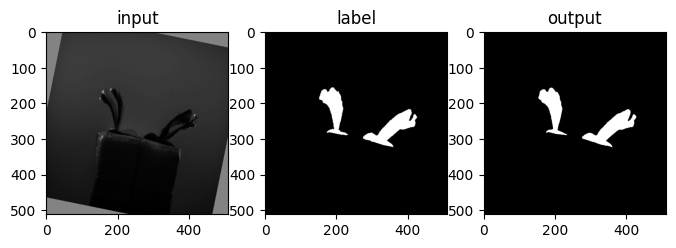

In [32]:
## 플롯 그리기
plt.figure(figsize=(8,6))
plt.subplot(131)
plt.imshow(input, cmap='gray')
plt.title('input')

plt.subplot(132)
plt.imshow(label, cmap='gray')
plt.title('label')

plt.subplot(133)
plt.imshow(output, cmap='gray')
plt.title('output')

plt.show()

# Report

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve
import itertools

Data types:  int32 int32
Shapes:  (262144,) (262144,)
Label sample:  [0 0 0 ... 0 0 0]
Output sample:  [0 0 0 ... 0 0 0]
Accuracy: 0.998199462890625
Precision: 0.9588396707173658
Recall: 0.9947132980886539
F1 Score: 0.9764471057884232


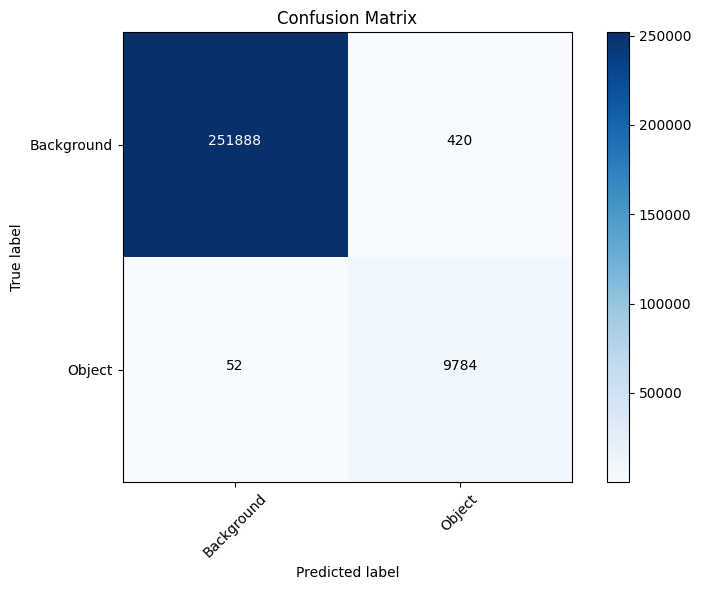

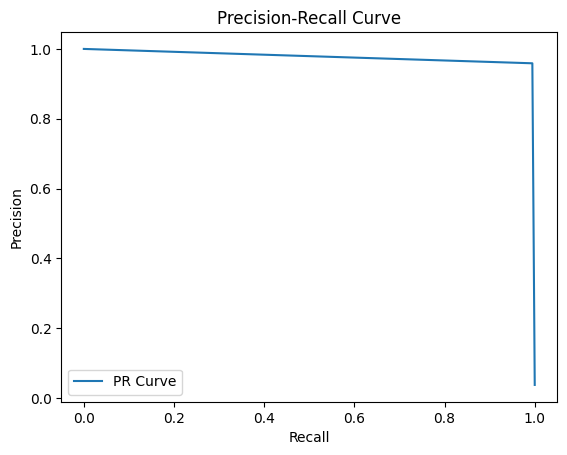

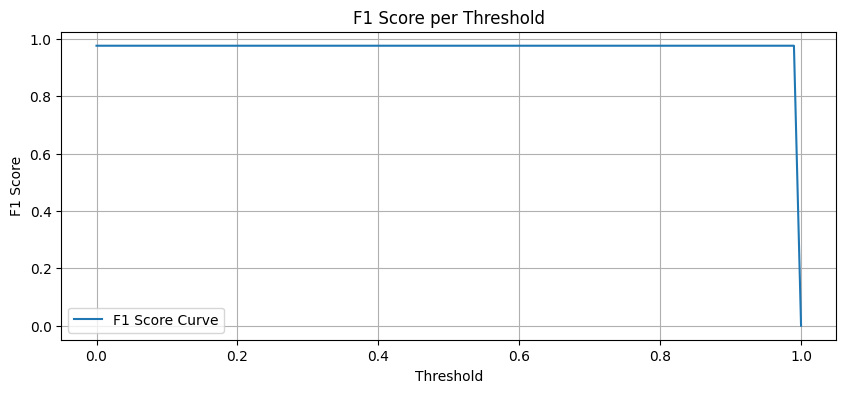

In [29]:
threshold = 0.5  # 임계값 설정

# 모델 출력을 이진 형태로 변환 (np.int 대신 np.int32 사용)
output_binary = (output > threshold).astype(np.int32)
label_flat = label.flatten().astype(np.int32)
output_flat = output_binary.flatten().astype(np.int32)

# 데이터 유형과 형태 확인
print("Data types: ", label_flat.dtype, output_flat.dtype)
print("Shapes: ", label_flat.shape, output_flat.shape)

# 데이터 샘플 출력
print("Label sample: ", label_flat[:len(test_set)])
print("Output sample: ", output_flat[:len(test_set)])

# 이진화된 출력으로 지표 계산
try:
    accuracy = accuracy_score(label_flat, output_flat)
    precision = precision_score(label_flat, output_flat, average='binary')
    recall = recall_score(label_flat, output_flat, average='binary')
    f1 = f1_score(label_flat, output_flat, average='binary')

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
except ValueError as e:
    print("Error in metric calculation: ", e)

# Confusion Matrix 계산 및 시각화
cm = confusion_matrix(label_flat, output_flat)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = ['Background', 'Object']  # 클래스 이름
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# 텍스트 추가
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

# PR Curve 계산 및 시각화
precision_array, recall_array, _ = precision_recall_curve(label_flat, output_flat)
plt.figure()
plt.plot(recall_array, precision_array, label='PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# 여러 임계값에 대한 F1 점수 계산
thresholds = np.linspace(0, 1, num=100)
f1_scores = []

for t in thresholds:
    output_binary_t = (output > t).astype(np.int32).flatten()
    f1_t = f1_score(label_flat, output_binary_t, average='binary')
    f1_scores.append(f1_t)

# F1 Score Curve 시각화
plt.figure(figsize=(10, 4))
plt.plot(thresholds, f1_scores, label='F1 Score Curve')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score per Threshold')
plt.legend()
plt.grid(True)
plt.show()

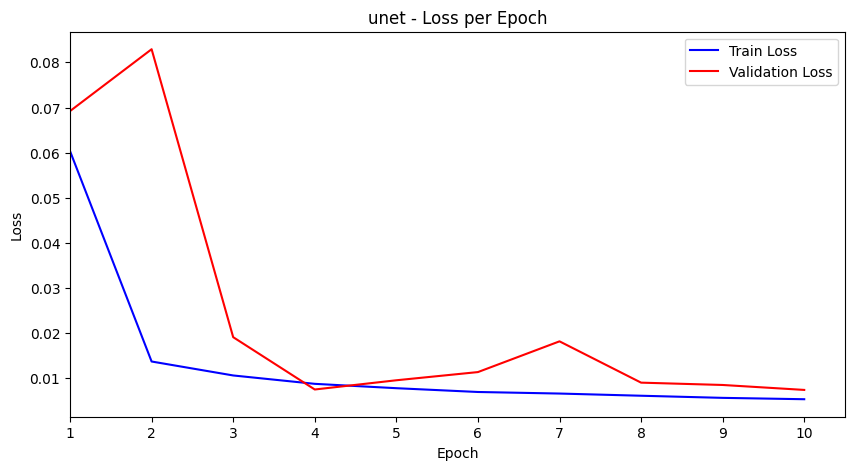

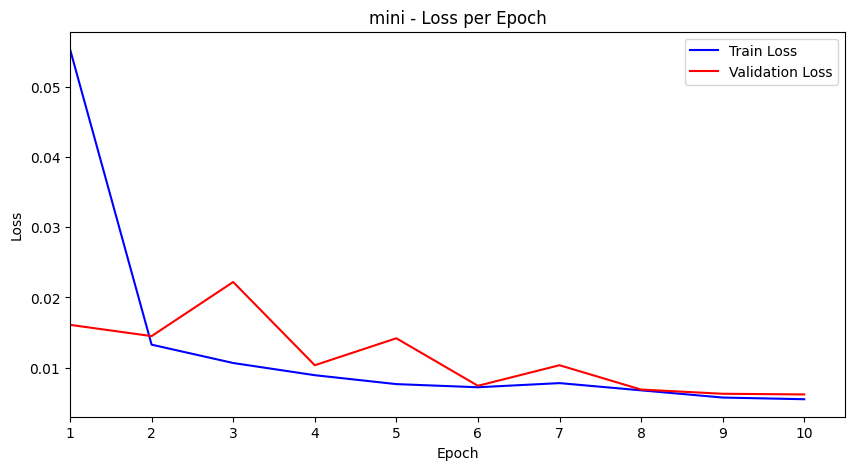

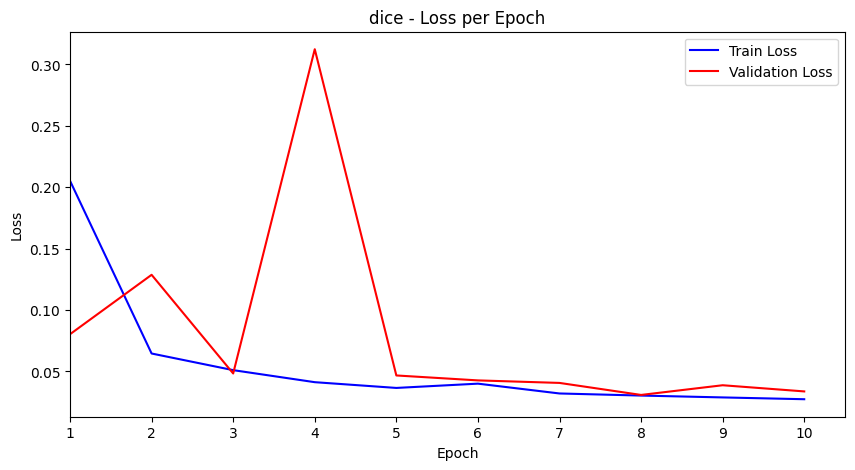

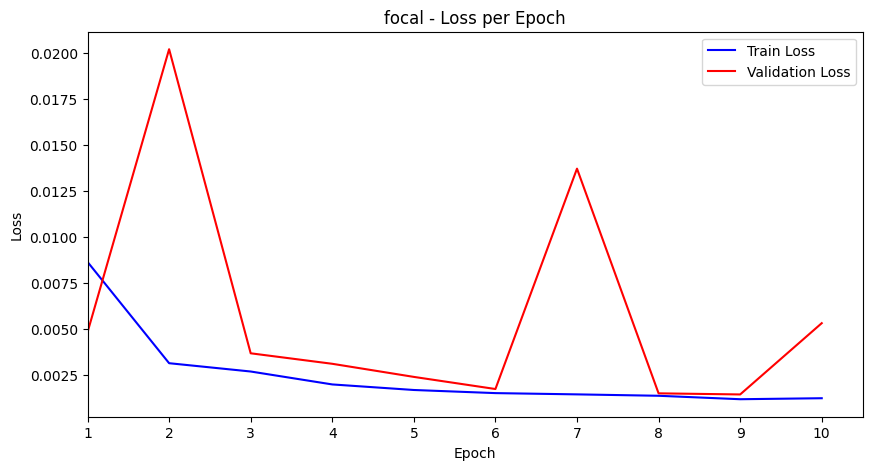

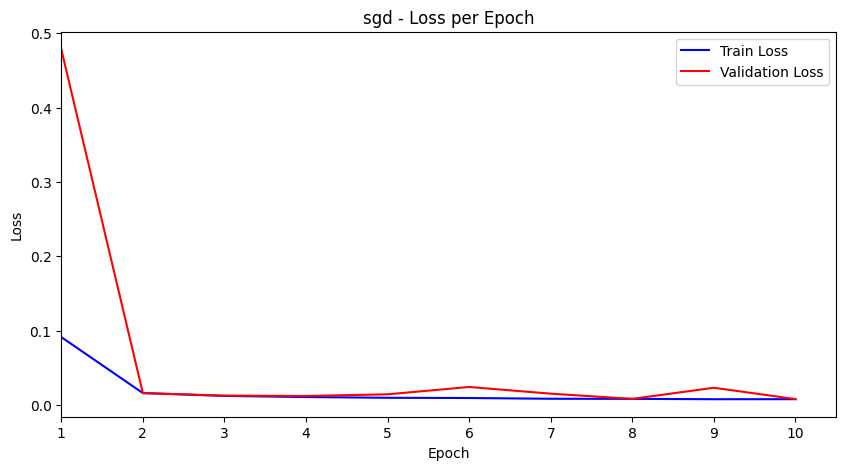

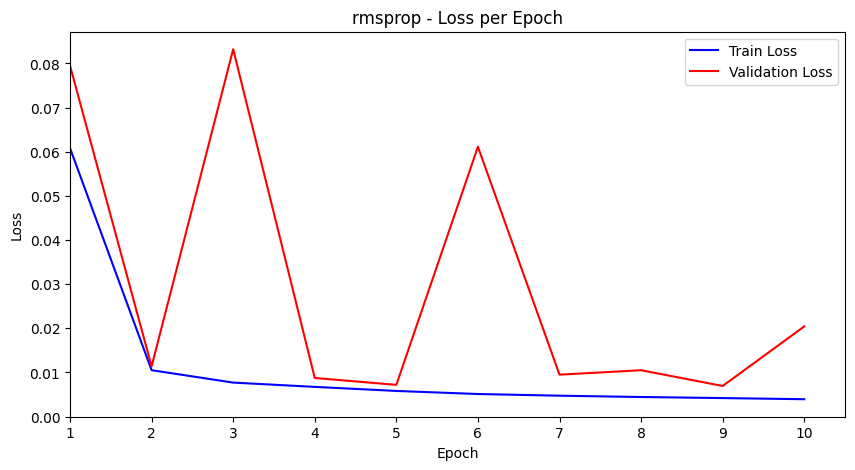

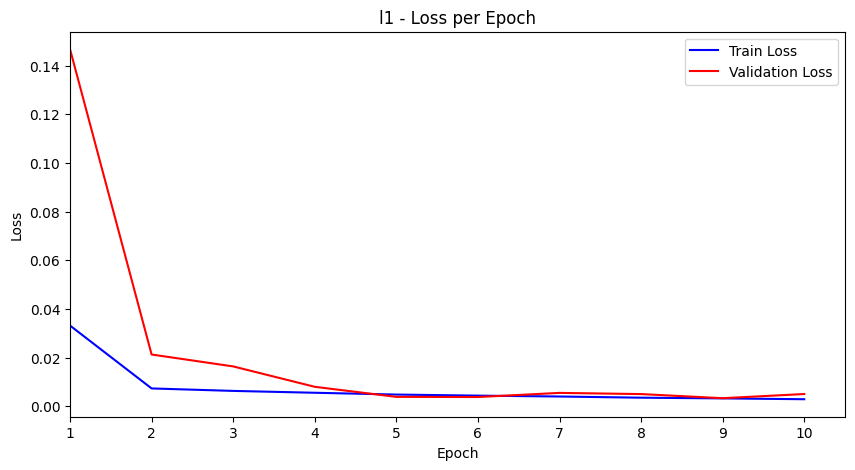

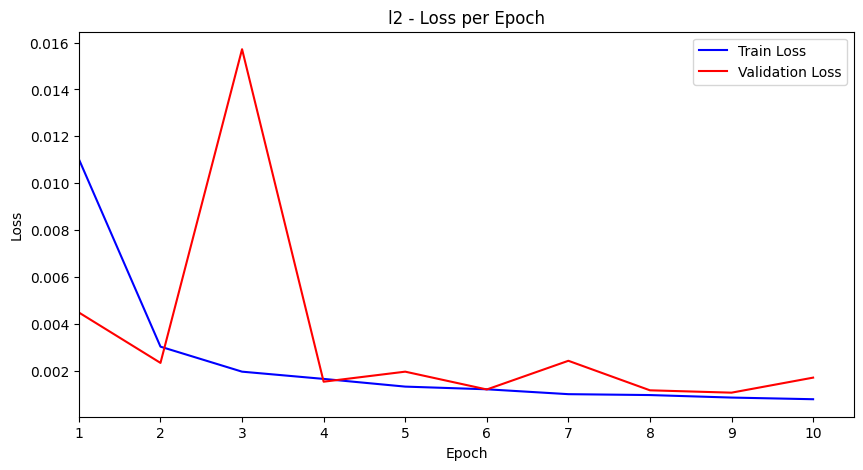

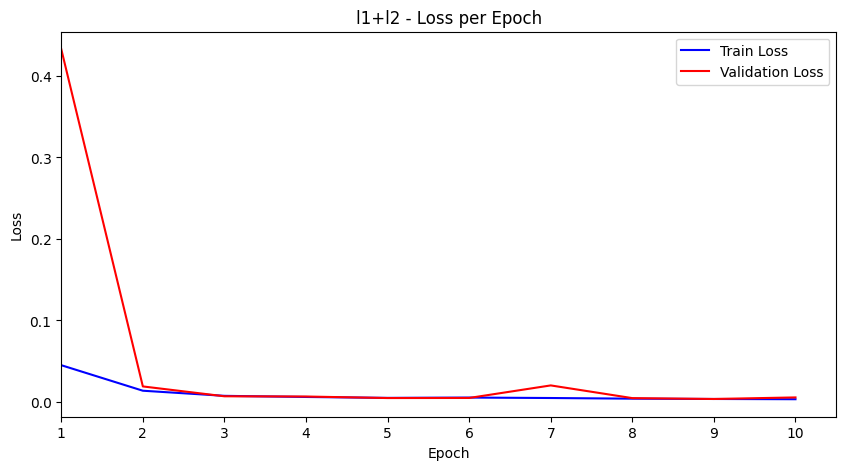

In [48]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

log_dir = './loss-log/'
log_files = ['unet',
'mini',
'dice',
'focal',
'sgd',
'rmsprop',
'l1',
'l2',
'l1+l2',
]
log_ext = '.log'

for log_file in log_files:
    with open(log_dir + log_file + log_ext, 'r') as log_data:
        train_loss_per_epoch = defaultdict(list)
        val_loss_per_epoch = defaultdict(list)

        for line in log_data:
            if "TRAIN" in line:
                epoch = int(line.split('|')[0].split()[2])
                loss = float(line.split('|')[2].split()[1])
                train_loss_per_epoch[epoch].append(loss)

            elif "VALID" in line:
                epoch = int(line.split('|')[0].split()[2])
                loss = float(line.split('|')[2].split()[1])
                val_loss_per_epoch[epoch].append(loss)

        train_loss_avg = [np.mean(train_loss_per_epoch[e]) for e in sorted(train_loss_per_epoch)]
        val_loss_avg = [np.mean(val_loss_per_epoch[e]) for e in sorted(val_loss_per_epoch)]
        # train_loss_avg = [np.mean(train_loss_per_epoch[e]) for e in train_loss_per_epoch]
        # val_loss_avg = [np.mean(val_loss_per_epoch[e]) for e in val_loss_per_epoch]
        epochs = range(1, len(train_loss_avg) + 1)

        max_y = np.maximum(train_loss_avg, val_loss_avg)

        plt.figure(figsize=(10, 5))
        plt.plot(epochs, train_loss_avg, label='Train Loss', color='blue')
        plt.plot(epochs, val_loss_avg, label='Validation Loss', color='red')

        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(log_file + ' - Loss per Epoch')
        plt.legend()
        plt.xticks(epochs)
        plt.xlim([1.0, 10.5])
        plt.show()
